In [5]:
import pandas as pd

# Balancing the Classes

Here we do a quick approach to balancing the classes, by augmenting the dataset with non-regulation financial data.

We bring in data from the [Financial Phrasebank](https://huggingface.co/datasets/financial_phrasebank) which brings about 5000 more negative classes.

This has the effect of balancing the classes, however it has the drawback of introducing non-real data which make create other biases in the model.
One key difference with the external dataset is the length of each passage, this will skew models that use sparse-vectors due to a much sparser representation
of each document.

We do some limited pre-processing to bias the new data away from "Regulatory" content, by filtering out any sentences with the substring "regul".
While this should be done with care, to be able to do it perfectly would be to have already solved the problem of the challange.


In [110]:
# load in the phrasebank data
with open('../data/all-data.csv') as f:
    lines = f.readlines()

# clean and screen each line.
clean = []    
for line in lines:
    line = line.split(',')
    line = line[1].replace('"','')
    if "reg" not in line:
        clean.append({"text":line, "label":0, "source":"phrasebank"})

In [111]:
# Combine the synthetic dataset with the core dataset
df = pd.read_table('../rnr-examples.csv', sep=",", header=0, encoding='utf-8')
# add a source field so we can characterise how well these synthetic data integrate.
df["source"] = ["core" for _ in range(len(df))]

# Combine and export
extended = pd.concat([df,pd.DataFrame(clean)])
extended.to_csv("../data/extended_data.csv")


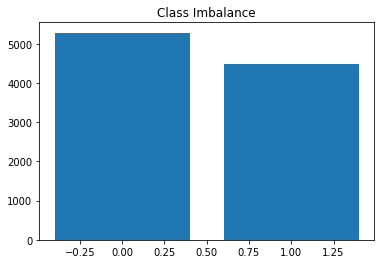

In [138]:
from collections import Counter
import matplotlib.pyplot as plt
classes = Counter(extended["label"].to_list())

fig = plt.bar(classes.keys(),classes.values())
plt.title("Class Imbalance")
plt.savefig('../data/images/class Imbalance.png', bbox_inches='tight')

# Extended Data Evaluation

Here we investigate the effect of balancing the data sets.
The Hypothsis here is that a balanced dataset will create a more robust classifier. 

We will investigate the effects over a single test-train split for simplicity. 

We will examine both the Confusion Matrix and the Accuracy

In [113]:
# Create a basic model for dataset interrorgation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Here we separate out a train-test split, and recreate the original train-test split on the core data alone.
test, train = train_test_split(extended)
unbalanced_train = train[train["source"]=="core"]
unbalanced_test = test[test["source"]=="core"]

In [115]:
# Train an unbalanced model, replicating the original data set class imbalance
clf_unbalanced = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf',  RandomForestClassifier()),
])

clf_unbalanced.fit(unbalanced_train["text"], unbalanced_train["label"])

# Train an balanced model, drawing on the balanced classes
clf_balanced = clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf',  RandomForestClassifier()),
])

clf_balanced.fit(train["text"], train["label"])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [116]:
# Evaluate the balanced and unbalanced models against the balanced and core-data
y_pred_balanced = clf_balanced.predict(test["text"])
y_pred_unbalanced = clf_unbalanced.predict(test["text"])
y_pred_unbalanced_core = clf_unbalanced.predict(unbalanced_test["text"])

In [127]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
print("Balanced Model on Balanced Data")
print(confusion_matrix(y_pred_balanced, test["label"]))
print("Accuracy:", accuracy_score(y_pred_balanced, test["label"]))
print("Precision:", precision_score(y_pred_balanced, test["label"]))
print("Recall:", recall_score(y_pred_balanced, test["label"]))

Balanced Model on Balanced Data
[[3695   53]
 [ 284 3308]]
Accuracy: 0.9540871934604904
Precision: 0.9842308836655758
Recall: 0.920935412026726


In [140]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
def print_metrics(title, y_pred, y_true):
    print(title)
    print(confusion_matrix(y_pred, y_true))
    print("Accuracy:", accuracy_score(y_pred, y_true))
    print("Precision:", precision_score(y_pred, y_true))
    print("Recall:", recall_score(y_pred, y_true))

In [128]:
print("Unbalanced Model on balanced Data")
print(confusion_matrix(y_pred_unbalanced, test["label"]))
print(accuracy_score(y_pred_unbalanced, test["label"]))
print("Accuracy:", accuracy_score(y_pred_unbalanced, test["label"]))
print("Precision:", precision_score(y_pred_unbalanced, test["label"]))
print("Recall:", recall_score(y_pred_unbalanced, test["label"]))

Unbalanced Model on balanced Data
[[  50    0]
 [3929 3361]]
0.4647138964577657
Accuracy: 0.4647138964577657
Precision: 1.0
Recall: 0.46104252400548695


In [126]:
print("Unbalanced Model on Unbalanced Data")
print(confusion_matrix(y_pred_unbalanced_core, unbalanced_test["label"]))
print("Accuracy:", accuracy_score(y_pred_unbalanced_core, unbalanced_test["label"]))
print("Accuracy:", accuracy_score(y_pred_unbalanced_core, unbalanced_test["label"]))
print("Precision:", precision_score(y_pred_unbalanced_core, unbalanced_test["label"]))
print("Recall:", recall_score(y_pred_unbalanced_core, unbalanced_test["label"]))

Unbalanced Model on Unbalanced Data
[[  50    0]
 [ 326 3361]]
Accuracy: 0.9127642493979128
Accuracy: 0.9127642493979128
Precision: 1.0
Recall: 0.9115812313534039
